In [ ]:
!pip install xlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 21.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for xlearn: filename=xlearn-0.40a1-py3-none-any.whl size=225734 sha256=1124b079d672012f03ecdab57640121419accbbc5add3a22b27baed291c9c003
  Stored in directory: /root/.cache/pip/wheels/09/48/04/779ee06b22532c86cde8da8984b83284517492dad1df998c6a
Successfully built xlearn


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import xlearn as xl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ParameterGrid
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import log_loss, roc_auc_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
data = pd.read_csv('data-001.csv')
columns_to_remove = ['banner_id0', 'rate0', 'g0', 'coeff_sum0', 'banner_id1', 'rate1', 'g1', 'coeff_sum1']
data = data.drop(columns=columns_to_remove)
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,1,1


In [ ]:
# Анализ данных: выводит информацию об отсутствующих значениях, уникальных значениях и описательную статистику датасета
def print_analysis(data):
    data_copy = data.copy()
    print(f'Empty values: \n{data.isnull().sum()}')
    print(f'Unique values: \n{data.nunique()}')
    print(data_copy.describe())

# Визуализация ежедневного тренда: строит графики суммарного числа показов (impressions) и кликов (clicks) по дням
def plot_daily_trend(data):
    data_copy = data.copy()
    data_copy['date_time'] = pd.to_datetime(data_copy['date_time'])
    data_copy['date'] = data_copy['date_time'].dt.date
    daily_impressions = data_copy.groupby('date')['impressions'].sum()
    daily_clicks = data_copy.groupby('date')['clicks'].sum()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Impressions', color=color)
    ax1.plot(daily_impressions.index, daily_impressions, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Clicks', color=color)
    ax2.plot(daily_clicks.index, daily_clicks, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Daily Impressions and Clicks Trend')
    plt.show()

# Визуализация корреляционной матрицы
def plot_correlation(data):
    data_copy = data.copy()
    numeric_data = data_copy.select_dtypes(include=[np.number])
    correlation_matrix = numeric_data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

# Визуализация кликов и показов по времени суток и дням недели
def plot_clicks_by_time(data):
    data_copy = data.copy()
    data_copy['date_time'] = pd.to_datetime(data_copy['date_time'])
    data_copy['time_of_day'] = pd.cut(data_copy['date_time'].dt.hour,
                                   bins=[0, 6, 12, 18, 24],
                                   labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                                   right=False)
    data_copy['day_of_week'] = data_copy['date_time'].dt.day_name()

    plt.figure(figsize=(12, 6))
    ax1 = sns.barplot(x='time_of_day', y='clicks', data=data_copy, estimator=sum, order=['Night', 'Morning', 'Afternoon', 'Evening'], ci=None)
    ax2 = ax1.twinx()
    ax2 = sns.lineplot(x='time_of_day', y='impressions', data=data_copy.groupby('time_of_day')['impressions'].sum().reset_index(), color='orange')

    ax1.set_title('Clicks and Impressions by Time of Day')
    ax1.set_xlabel('Time of Day')
    ax1.set_ylabel('Total Clicks', color='blue')
    ax2.set_ylabel('Total Impressions', color='orange')
    plt.show()

    plt.figure(figsize=(12, 6))
    ax1 = sns.barplot(x='day_of_week', y='clicks', data=data_copy, estimator=sum,
                      order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ci=None)
    ax2 = ax1.twinx()
    ax2 = sns.lineplot(x='day_of_week', y='impressions', data=data_copy.groupby('day_of_week')['impressions'].sum().reset_index(), color='orange')

    ax1.set_title('Clicks and Impressions by Day of Week')
    ax1.set_xlabel('Day of Week')
    ax1.set_ylabel('Total Clicks', color='blue')
    ax2.set_ylabel('Total Impressions', color='orange')

    plt.show()

# Основная функция анализа: вызывает все вышеуказанные функции
def analysis(data):
    print_analysis(data)
    plot_daily_trend(data)
    plot_correlation(data)
    plot_clicks_by_time(data)


Empty values: 
date_time          0
zone_id            0
banner_id          0
oaid_hash          0
campaign_clicks    0
os_id              0
country_id         0
impressions        0
clicks             0
dtype: int64
Unique values: 
date_time           604712
zone_id               3444
banner_id             1633
oaid_hash          6510316
campaign_clicks        822
os_id                   11
country_id              17
impressions              1
clicks                   2
dtype: int64
            zone_id     banner_id     oaid_hash  campaign_clicks  \
count  1.582147e+07  1.582147e+07  1.582147e+07     1.582147e+07   
mean   8.152679e+01  3.816483e+02  4.610505e+18     6.238540e-01   
std    1.632448e+02  3.959386e+02  2.663858e+18     9.249152e+00   
min    0.000000e+00  0.000000e+00  1.116911e+12     0.000000e+00   
25%    1.400000e+01  5.200000e+01  2.297977e+18     0.000000e+00   
50%    1.900000e+01  2.170000e+02  4.614236e+18     0.000000e+00   
75%    6.000000e+01  6.110000e+02  

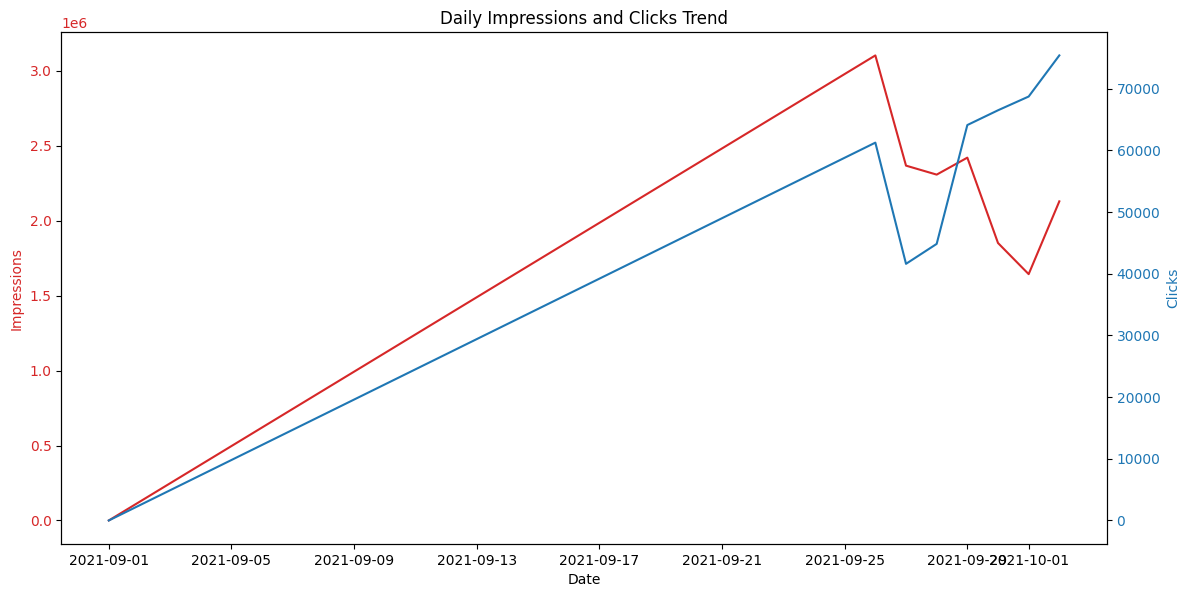

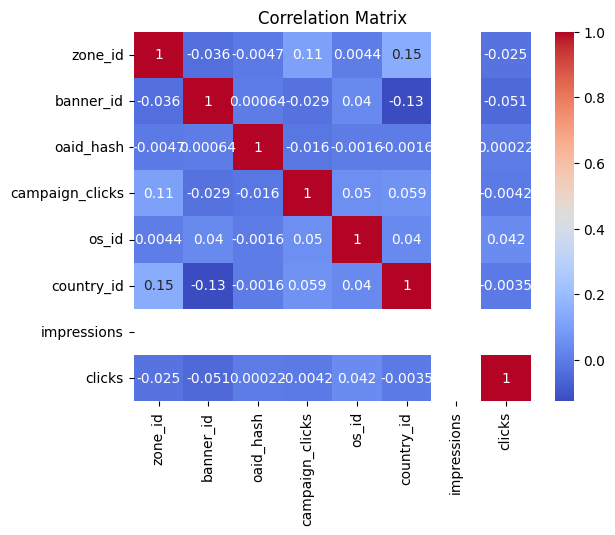

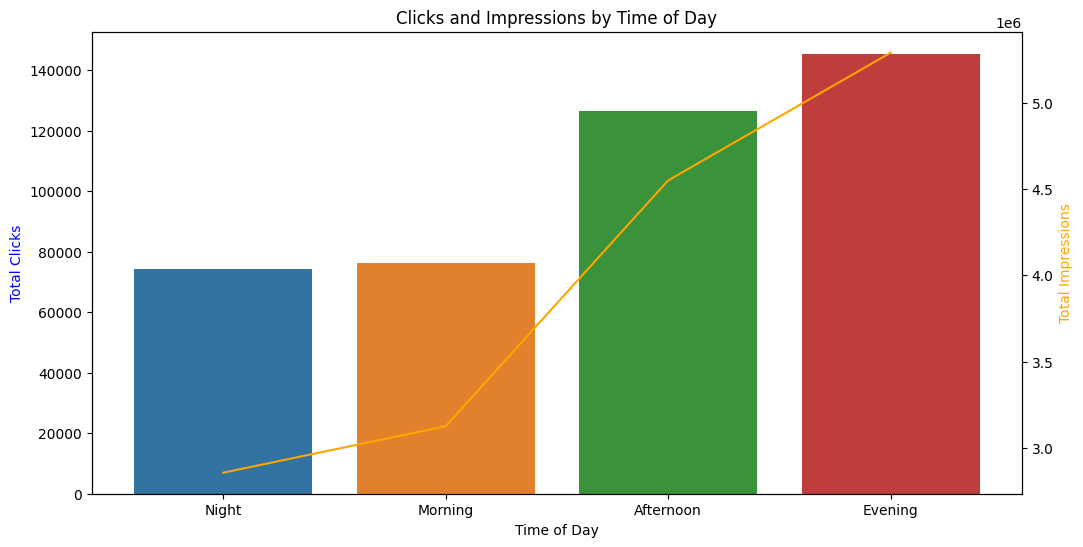

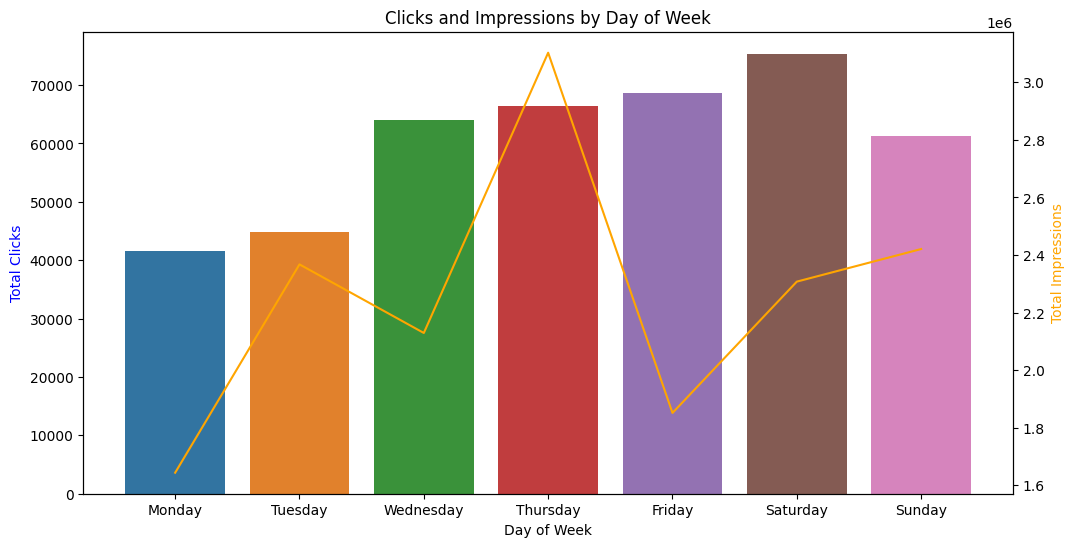

In [ ]:
analysis(data)

Можем сделать следующие выводы:

1. Пустых значений нет

2. Есть выброс в данных - 2021.09.01, который надо удалить

3. Явной линейной зависимости фичей (исходя из корреляционной матрицы) нет

4. В последобеденное и вечернее время кликов (как и показов) больше, следовательно есть смысл сделать фичу по временам суток

5. Не видно связи в количестве кликов между выходными и невыходными днями (как-будто такая фича не особо нужна), но видим зависимость между числом показов и числом кликов в зависимости от дня недели.

In [ ]:
def feature_engineering(data: pd.DataFrame) -> (pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series):
    # Удаляем столбец 'impressions'
    data = data.drop(['impressions'], axis=1)

    # Фильтруем данные по времени
    data['date_time'] = pd.to_datetime(data['date_time'])
    data = data[data['date_time'] > '2021-09-20']

    # Добавление фичи "Время суток"
    data['time_of_day'] = pd.cut(data['date_time'].dt.hour,
                                 bins=[0, 6, 12, 18, 24],
                                 labels=['Night', 'Morning', 'Afternoon', 'Evening'])

    # Добавление фичи "День недели"
    data['day_of_week'] = data['date_time'].dt.day_name()


    # Разделение на обучающий и тестовый наборы
    train_data = data[data['date_time'] < '2021-10-02']
    test_data = data[data['date_time'] >= '2021-10-02']

    # Дополнительное разделение train_data на тренировочный и валидационный наборы
    train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

    #'clicks' оставляем в x, тк таргет нужен для конвертации в формат для fft
    x_train = train_data
    y_train = train_data['clicks']
    x_val = val_data
    y_val = val_data['clicks']
    x_test = test_data
    y_test = test_data['clicks']

    return x_train, y_train, x_val, y_val, x_test, y_test


In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = feature_engineering(data)

In [ ]:
#Функция для конвертации в формат libffm

def convert_to_libffm_format(data, filename):
    y = data['clicks']
    X = data.drop(['clicks'], axis=1)
    X_dict = X.to_dict(orient='records')

    vectorizer = DictVectorizer(separator=':')
    X_vectorized = vectorizer.fit_transform(X_dict)

    feature_names = vectorizer.get_feature_names_out()
    field_indices = {name.split(':')[0]: i for i, name in enumerate(feature_names)}

    with open(filename, "w") as f:
        for _, (label, row) in tqdm(enumerate(zip(y, X_vectorized)), total=len(y)):
            result_row = f'{label}'
            for i, v in zip(row.indices, row.data):
                feature_name = feature_names[i]
                field_index = field_indices[feature_name.split(':')[0]]
                result_row += f' {field_index}:{i}:{v}'

            f.write(result_row + '\n')

In [ ]:
convert_to_libffm_format(x_val, 'val_ffm.txt')
convert_to_libffm_format(x_test, 'test_ffm.txt')
convert_to_libffm_format(x_train, 'train_ffm.txt')

100%|██████████| 10953994/10953994 [12:33<00:00, 14533.07it/s]


In [ ]:
# Загрузка тренировочных и валидационных данных
VAL = 'val_ffm.txt'
TRAIN = 'train_ffm.txt'

# Функция для обучения и оценки модели
def train_and_evaluate(params, train_file, val_file, y_val):
    model = xl.create_ffm()
    model.setTrain(train_file)
    model.setTest(val_file)
    param = {'task':'binary', 'lr': 0.1, 'lambda': params['lambda'], 'k': params['k'], 'metric': 'auc'}

    model.fit(param, './model.out')
    model.setSigmoid()
    model.predict('./model.out', './output.txt')

    with open('output.txt', 'r') as f:
        y_pred_proba = np.array([float(line) for line in f if line.strip()])

    roc_auc = roc_auc_score(y_val, y_pred_proba)
    log_loss_val = log_loss(y_val, y_pred_proba)
    return roc_auc, log_loss_val

# Определение сетки параметров для поиска
param_grid = {'k': [2, 4], 'lambda': [0.00001, 0.0001, 0.001, 0.01]}
grid = ParameterGrid(param_grid)
results = []

# Перебор параметров и обучение моделей
for params in grid:
    print(f'Training with parameters: {params}')
    roc_auc, log_loss_val = train_and_evaluate(params, TRAIN, VAL, y_val)
    results.append({'params': params, 'roc_auc': roc_auc, 'log_loss': log_loss_val})
    print(f'roc_auc = {roc_auc}, log_loss = {log_loss_val}')

# Вывод результатов
for result in results:
    print(result)

Training with parameters: {'k': 2, 'lambda': 1e-05}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x auc) option.
[------------] xLearn uses 4 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train_ffm.txt.bin) NOT found. Convert text file to binary file.
[------------] Number of Feature: 4897531
[------------] Number of Field: 8
[------------] Time

Видим, что k = 4 и lambda = 0.0001 - лучшие параметры и совсем немного уступает k = 2 при lambda = 0.0001.

Можно попробовать дополнительно проверить k = 6 и k = 8 вместе с lambda = [0.00001, 0.0001, 0.001]

In [ ]:
# Определение сетки параметров для поиска
param_grid = {'k': [6, 8], 'lambda': [0.00001, 0.0001, 0.001]}
grid = ParameterGrid(param_grid)
results = []

# Перебор параметров и обучение моделей
for params in grid:
    print(f'Training with parameters: {params}')
    roc_auc, log_loss_val = train_and_evaluate(params, TRAIN, VAL, y_val)
    results.append({'params': params, 'roc_auc': roc_auc, 'log_loss': log_loss_val})
    print(f'roc_auc = {roc_auc}, log_loss = {log_loss_val}')

# Вывод результатов
for result in results:
    print(result)

Training with parameters: {'k': 6, 'lambda': 1e-05}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x auc) option.
[------------] xLearn uses 4 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train_ffm.txt.bin) NOT found. Convert text file to binary file.
[------------] Number of Feature: 4897531
[------------] Number of Field: 8
[------------] Time

Лучшие параметры: k = 8, lambda = 0.0001

Видим, что наилучшая lambda не меняется, но можем попробовать больше k

In [ ]:
# Определение сетки параметров для поиска
param_grid = {'k': [10, 12], 'lambda': [0.0001]}
grid = ParameterGrid(param_grid)
results = []

# Перебор параметров и обучение моделей
for params in grid:
    print(f'Training with parameters: {params}')
    roc_auc, log_loss_val = train_and_evaluate(params, TRAIN, VAL, y_val)
    results.append({'params': params, 'roc_auc': roc_auc, 'log_loss': log_loss_val})
    print(f'roc_auc = {roc_auc}, log_loss = {log_loss_val}')

# Вывод результатов
for result in results:
    print(result)

Training with parameters: {'k': 10, 'lambda': 0.0001}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x auc) option.
[------------] xLearn uses 4 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 4897531
[------------] Number of Field: 8
[------------] Time cos

На k = 12 скор пошел вниз, оставим k = 10

In [ ]:
# Параметры лучшей модели
best_params = {'k': 10, 'lambda': 0.0001}
# Загрузка тестовых данных
TEST = 'test_ffm.txt'

# Функция для обучения и предсказания на тестовом датасете
def train_and_predict(train_file, test_file, params):
    model = xl.create_ffm()
    model.setTrain(train_file)
    model.setTest(test_file)
    param = {'task':'binary', 'lr': 0.1, 'lambda': params['lambda'], 'k': params['k'], 'metric': 'auc'}

    model.fit(param, './model.out')

    model.setSigmoid()
    model.predict('./model.out', './output.txt')

    with open('output.txt', 'r') as f:
        y_pred_proba = np.array([float(line) for line in f if line.strip()])

    return y_pred_proba


# Выполнение предсказаний
y_pred_proba = train_and_predict(TRAIN, TEST, best_params)

# Расчет метрик
roc_auc = roc_auc_score(y_test, y_pred_proba)
log_loss_val = log_loss(y_test, y_pred_proba)

# Вывод результатов
print(f'Log Loss on test data: {log_loss_val}, AUC on test data: {roc_auc}')

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[ WARNING    ] Validation file not found, xLearn has already disable (-x auc) option.
[------------] xLearn uses 4 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 4897531
[------------] Number of Field: 8
[------------] Time cost for reading problem: 16.67 (sec)
[ ACTION     ] Init

Результаты прошлого раза:

Log Loss on test data: 0.13647059187763738

AUC on test data: 0.7687202651941554

Значительно улучшился скор. Успех!